In [184]:
#install numpy, pandas, matplolib, tensorflow, sklearn, pandas_datareader, seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from time import sleep
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

import seaborn as sns
import pandas_datareader as pd_dr

In [185]:
#Données d'entrainement doivent être différentes des données de test donc on s'arrete en 2019...
training_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2015,1,1), dt.datetime(2020,12,30) )
testing_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2021,1,1), dt.datetime.now() )
#Drop la adj Close

In [186]:
trend_training_data = training_data.copy()
trend_testing_data = testing_data.copy()

In [187]:
#trend preprocessing
trend_training_data_j1 = trend_training_data.shift(periods=1)
trend_testing_data_j1 = trend_testing_data.shift(periods=1)

#creation de la colonne tendance, dans laquelle on soustrait le prix du jour actuel au prix j-1
trend_training_data['Diff_J+1'] = trend_training_data["Close"] - trend_training_data_j1["Close"]
trend_testing_data['Diff_J+1'] = trend_testing_data["Close"] - trend_testing_data_j1["Close"]

#dans la colonne tendance, on remplace toutes les tendance de prix par True si elles augmentent et par False si elle diminue
trend_training_data["Diff_J+1"].loc[trend_training_data["Diff_J+1"] >= 0] = True
trend_training_data["Diff_J+1"].loc[trend_training_data["Diff_J+1"] < 0] = False

trend_testing_data["Diff_J+1"].loc[trend_testing_data["Diff_J+1"] >= 0] = True
trend_testing_data["Diff_J+1"].loc[trend_testing_data["Diff_J+1"] < 0] = False

#suppression des lignes avec NaN (la premiere n'a pas de tendance vu qu'on a pas de jour precedent
#on supprime la ligne plutot que de mettre une donnée fausse car il y'a 2192 lignes)
trend_training_data.dropna(subset = ["Diff_J+1"], inplace=True)

trend_training_data["Diff_J+1"]= trend_training_data["Diff_J+1"].astype('bool')
trend_testing_data["Diff_J+1"]= trend_testing_data["Diff_J+1"].astype('bool')

C:\Users\owcha\AppData\Local\Temp\ipykernel_16352\2998757128.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_training_data["Diff_J+1"].loc[trend_training_data["Diff_J+1"] >= 0] = True


In [188]:
print( trend_training_data['Diff_J+1'].value_counts() )
print( trend_testing_data['Diff_J+1'].value_counts() )

True     1208
False     983
Name: Diff_J+1, dtype: int64
True     221
False    215
Name: Diff_J+1, dtype: int64


In [195]:
print( trend_training_data.shape )

trend_training_x = trend_training_data.drop(columns=['Diff_J+1'])
print( trend_training_x.shape )
trend_training_y = trend_training_data['Diff_J+1']
print( trend_training_y.shape )


trend_testing_x = trend_testing_data.drop(columns=['Diff_J+1'])
print( trend_testing_x.shape )
trend_testing_y = trend_testing_data['Diff_J+1']
print( trend_testing_y.shape )
print( trend_testing_y.head )

trend_scaler = MinMaxScaler( feature_range=(0,1) ) 
trend_training_x = trend_scaler.fit_transform(trend_training_x)
trend_testing_x = trend_scaler.fit_transform(trend_testing_x)

(2191, 7)
(2191, 6)
(2191,)
(436, 6)
(436,)
<bound method NDFrame.head of Date
2021-01-01     True
2021-01-02     True
2021-01-03     True
2021-01-04    False
2021-01-05     True
              ...  
2022-03-08     True
2022-03-09     True
2022-03-10    False
2022-03-11    False
2022-03-13     True
Name: Diff_J+1, Length: 436, dtype: bool>


In [196]:
#Random Forest Model
model = RandomForestClassifier(criterion = 'entropy', max_depth=30)
model.fit( trend_training_x, trend_training_y )

RandomForestClassifier(criterion='entropy', max_depth=30)

0.7981651376146789
<bound method NDFrame.head of Date
2021-01-01     True
2021-01-02     True
2021-01-03     True
2021-01-04    False
2021-01-05     True
              ...  
2022-03-08     True
2022-03-09     True
2022-03-10    False
2022-03-11    False
2022-03-13     True
Name: Diff_J+1, Length: 436, dtype: bool>
              precision    recall  f1-score   support

       False       0.89      0.67      0.77       215
        True       0.74      0.92      0.82       221

    accuracy                           0.80       436
   macro avg       0.82      0.80      0.79       436
weighted avg       0.82      0.80      0.79       436



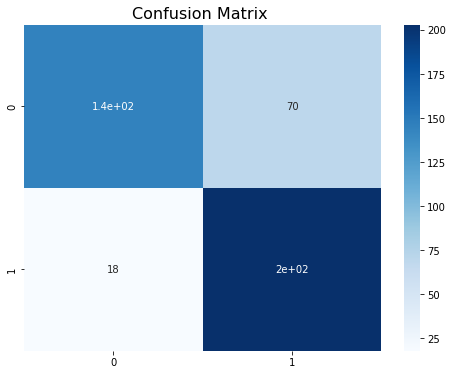

In [197]:
print( model.score( trend_testing_x, trend_testing_y ) )

trend_prediction = model.predict( trend_testing_x )

cm = confusion_matrix( trend_testing_y , trend_prediction )
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix ', size=16)
sns.heatmap(cm, annot=True, cmap='Blues')

print( classification_report( trend_testing_y , trend_prediction ) )

In [199]:
lstm_training_data = training_data.copy()
lstm_testing_data = testing_data.copy()

lstm_training_data['Predicted Trend'] = trend_training_y
lstm_training_data.dropna(subset = ["Predicted Trend"], inplace=True)

lstm_training_data = lstm_training_data.drop(['Adj Close'], axis='columns')
lstm_training_data["Predicted Trend"].loc[lstm_training_data["Predicted Trend"] == True] = 1.0
lstm_training_data["Predicted Trend"].loc[lstm_training_data["Predicted Trend"] == False] = 0.0


lstm_testing_data['Predicted Trend'] = trend_prediction
lstm_testing_data = lstm_testing_data.drop(['Adj Close'], axis='columns')
lstm_testing_data["Predicted Trend"].loc[lstm_testing_data["Predicted Trend"] == True] = 1.0
lstm_testing_data["Predicted Trend"].loc[lstm_testing_data["Predicted Trend"] == False] = 0.0


print( lstm_training_data.shape )
print( lstm_testing_data.shape )
print( lstm_training_data.head )
print( lstm_testing_data.head )

(2191, 6)
(436, 6)
<bound method NDFrame.head of                     High           Low          Open         Close  \
Date                                                                 
2015-01-02    315.838989    313.565002    314.079010    315.032013   
2015-01-03    315.149994    281.082001    314.846008    281.082001   
2015-01-04    287.230011    257.612000    281.145996    264.195007   
2015-01-05    278.341003    265.084015    265.084015    274.473999   
2015-01-06    287.553009    272.696014    274.610992    286.188995   
...                  ...           ...           ...           ...   
2020-12-27  28288.839844  25922.769531  26439.373047  26272.294922   
2020-12-28  27389.111328  26207.640625  26280.822266  27084.808594   
2020-12-29  27370.720703  25987.298828  27081.810547  27362.437500   
2020-12-30  28937.740234  27360.089844  27360.089844  28840.953125   
2020-12-31  29244.876953  28201.992188  28841.574219  29001.720703   

                 Volume Predicted Trend 

C:\Users\owcha\AppData\Local\Temp\ipykernel_16352\2109424596.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_training_data["Predicted Trend"].loc[lstm_training_data["Predicted Trend"] == True] = 1.0
C:\Users\owcha\AppData\Local\Temp\ipykernel_16352\2109424596.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_training_data["Predicted Trend"].loc[lstm_training_data["Predicted Trend"] == False] = 0.0
C:\Users\owcha\AppData\Local\Temp\ipykernel_16352\2109424596.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

In [200]:
#LSTM Preprocessing

scaler = MinMaxScaler( feature_range=(0,1) )

scaled_data = scaler.fit_transform( lstm_training_data ) 

#Fragmente le dataset en plusieurs packets
chunks_size = 90

lstm_training_x, lstm_training_y = list(), list()

for x in range( chunks_size, len(scaled_data) ):
    lstm_training_x.append(scaled_data[x-chunks_size:x])
    lstm_training_y.append(scaled_data[x])
    
lstm_training_x, lstm_training_y = np.array(lstm_training_x), np.array(lstm_training_y)

In [201]:
#Neural network
model = Sequential()

model.add( LSTM(units=60, return_sequences=True, input_shape=(lstm_training_x.shape[1], 6)) )
model.add( Dropout(0.2) )
model.add( LSTM(units=80, return_sequences=True) )
model.add( Dropout(0.3) ) 
model.add( LSTM(units=120) )
model.add( Dropout(0.4) ) 
model.add( Dense(units=6) )

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(lstm_training_x, lstm_training_y , epochs=30, batch_size=32, validation_split=0.1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 90, 60)            16080     
                                                                 
 dropout_21 (Dropout)        (None, 90, 60)            0         
                                                                 
 lstm_22 (LSTM)              (None, 90, 80)            45120     
                                                                 
 dropout_22 (Dropout)        (None, 90, 80)            0         
                                                                 
 lstm_23 (LSTM)              (None, 120)               96480     
                                                                 
 dropout_23 (Dropout)        (None, 120)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                

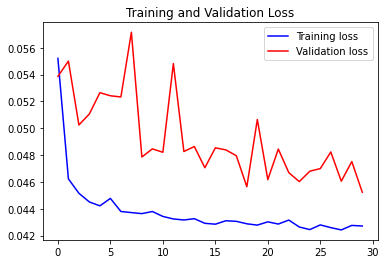

In [202]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

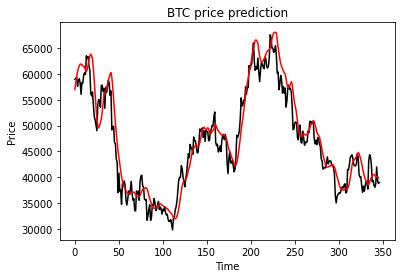

In [203]:
#Test du modèle
actual_prices = lstm_testing_data['Close'].values
actual_prices = actual_prices[89:x]

#actual_prices = actual_prices * scaler.scale_[3]

model_inputs = lstm_testing_data.values

model_inputs = scaler.fit_transform(model_inputs)

lstm_testing_x = list()
for x in range( chunks_size, len(model_inputs) ):
    lstm_testing_x.append( model_inputs[x-chunks_size:x] )
    
lstm_testing_x = np.array(lstm_testing_x)


prediction_prices = model.predict(lstm_testing_x)
prediction_prices = scaler.inverse_transform(prediction_prices)[:, [3]]

#prediction_prices.shape

plt.plot(actual_prices, color='black', label='actual_prices')
plt.plot(prediction_prices, color='red', label='predicted_prices')
plt.title('BTC price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()